Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Assess privacy risks with TensorFlow Privacy Membership Inference Attacks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/membership_inference_attack/codelabs/codelab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/membership_inference_attack/codelabs/codelab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

##Overview
In this codelab we'll train a simple image classification model on the CIFAR10 dataset, and then use the "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular sample was present in the training set. We further compute each sample's probability of being in the training set, denoted as the privacy risk score (https://arxiv.org/abs/2003.10595)

## Setup
First, set this notebook's runtime to use a GPU, under Runtime > Change runtime type > Hardware accelerator. Then, begin importing the necessary libraries.

In [2]:
#@title Import statements.
import numpy as np
from typing import Tuple, Text
from scipy import special

import tensorflow as tf
import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action="ignore", category=ConvergenceWarning)
simplefilter(action="ignore", category=FutureWarning)

### Install TensorFlow Privacy.

In [3]:
!pip3 install git+https://github.com/tensorflow/privacy

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

## Train a model

In [4]:
#@markdown Train a simple model on CIFAR10 with Keras.

dataset = 'cifar10'
num_classes = 10
num_conv = 3
activation = 'relu'
lr = 0.02
momentum = 0.9
batch_size = 250
epochs = 100  # Privacy risks are especially visible with lots of epochs.


def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: Text = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  return model


print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

model = small_cnn(
    input_shape, num_classes, num_conv=num_conv, activation=activation)

print('learning rate %f', lr)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True)
print('Finished training.')

Loading the dataset.
learning rate %f 0.02
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flat

200/200 [==============================] - 2s 9ms/step - loss: 0.5219 - accuracy: 0.8157 - val_loss: 1.0694 - val_accuracy: 0.6729
Epoch 47/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5232 - accuracy: 0.8121 - val_loss: 1.0447 - val_accuracy: 0.6902
Epoch 48/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5180 - accuracy: 0.8149 - val_loss: 1.0495 - val_accuracy: 0.6907
Epoch 49/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5022 - accuracy: 0.8217 - val_loss: 1.0147 - val_accuracy: 0.6941
Epoch 50/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5017 - accuracy: 0.8210 - val_loss: 1.0510 - val_accuracy: 0.6925
Epoch 51/100
200/200 [==============================] - 2s 9ms/step - loss: 0.4997 - accuracy: 0.8230 - val_loss: 1.0620 - val_accuracy: 0.6935
Epoch 52/100
200/200 [==============================] - 2s 10ms/step - loss: 0.5001 - accuracy: 0.8214 - val_loss: 1.1083 - val_accuracy: 0.6832


## Calculate logits, probabilities and loss values for training and test sets.

We will use these values later in the membership inference attack and privacy risk score analysis to separate training and test samples.

In [5]:
print('Predict on train...')
logits_train = model.predict(x_train, batch_size=batch_size)
print('Predict on test...')
logits_test = model.predict(x_test, batch_size=batch_size)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


## Run membership inference attacks.

We will now execute a membership inference attack against the previously trained CIFAR10 model. This will generate a number of scores, most notably, attacker advantage and AUC for the membership inference classifier.

An AUC of close to 0.5 means that the attack wasn't able to identify training samples, which means that the model doesn't have privacy issues according to this test. Higher values, on the contrary, indicate potential privacy issues.

Best-performing attacks over all slices
  LOGISTIC_REGRESSION achieved an AUC of 0.75 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION achieved an advantage of 0.39 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION achieved an AUC of 0.62
  LOGISTIC_REGRESSION achieved an advantage of 0.21

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION achieved an AUC of 0.65
  LOGISTIC_REGRESSION achieved an advantage of 0.28

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION achieved an AUC of 0.59
  THRESHOLD_ENTROPY_ATTACK achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=2"
  LOGISTIC_REGRESSION achieved an AUC of 0.72
  LOGISTIC_REGRESSION achieved an advantage of 0.33

Best-performing attacks over slice: "CLASS=3"
  LOGISTIC_REGRESSION achieved an AUC of 0.68
  LOGISTIC_REGRESSION achieved an advantage of 0.30

Best-performing attacks over slice: "CLASS=4"
  LOGI

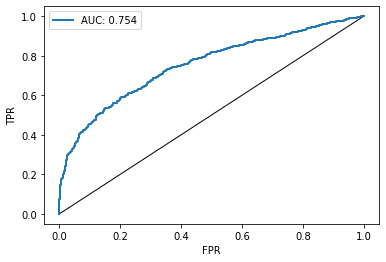

In [6]:
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting

labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(
                                     entire_dataset = True,
                                     by_class = True,
                                     by_classification_correctness = True
                                 ),
                                 attack_types = [
                                     AttackType.THRESHOLD_ATTACK,
                                     AttackType.THRESHOLD_ENTROPY_ATTACK,
                                     AttackType.LOGISTIC_REGRESSION])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

## Compute privacy risk score

This part shows how to use the privacy risk score.

For each data slice, we compute privacy risk scores for both training and test data. We then set a threshold on risk scores (an input is inferred as a member if and only if its risk score is higher than the threshold) and compute the attack precision and recall values

In [7]:
# compute privacy risk scores on all given data slices
risk_score_results = mia.run_privacy_risk_score_analysis(input,
                                                         SlicingSpec(
                                                             entire_dataset = True,
                                                             by_class = True,
                                                             by_classification_correctness = True))
# print the summary of privacy risk score analysis
print(risk_score_results.summary(threshold_list=[1, 0.9, 0.8, 0.7, 0.6, 0.5]))


Privacy risk score analysis over slice: "Entire dataset"
  with 0.60000 as the threshold on privacy risk score, the precision-recall pair is (0.60966, 0.10730)
  with 0.50000 as the threshold on privacy risk score, the precision-recall pair is (0.56588, 0.87102)

Privacy risk score analysis over slice: "CLASS=0"
  with 0.60000 as the threshold on privacy risk score, the precision-recall pair is (0.62251, 0.26880)
  with 0.50000 as the threshold on privacy risk score, the precision-recall pair is (0.57677, 0.74680)

Privacy risk score analysis over slice: "CLASS=1"
  with 0.60000 as the threshold on privacy risk score, the precision-recall pair is (0.61579, 0.23560)
  with 0.50000 as the threshold on privacy risk score, the precision-recall pair is (0.58356, 0.64880)

Privacy risk score analysis over slice: "CLASS=2"
  with 0.60000 as the threshold on privacy risk score, the precision-recall pair is (0.64815, 0.58580)
  with 0.50000 as the threshold on privacy risk score, the precision